### Building Random Co-Polymers
### Joe Laforet Jr.
#### jola3134@colorado.edu

This notebook serves as a self-contained utility for a user to input SMILES strings of monomers that can react together to form a polymer according to Atom-Transfer Radical Polymerization.

#### Logging

In [144]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing

MOL_IMG_WIDTH  : int = 300
MOL_IMG_HEIGHT : int = 200
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

#### Initiation with Polymerist (Halogenation of an Alkene)

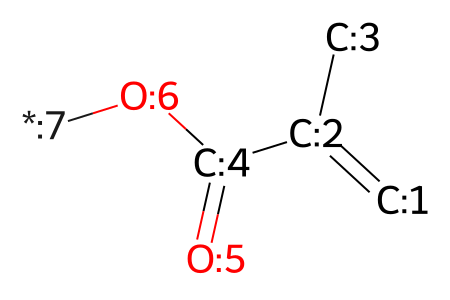

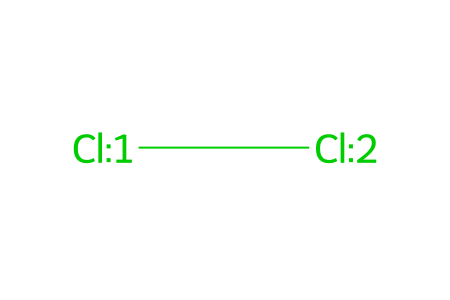

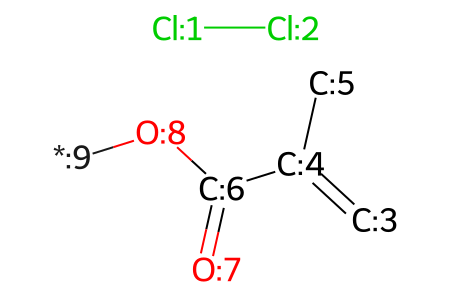

INFO:polymerist.rdutils.bonding.permutation:1 --x-> 2


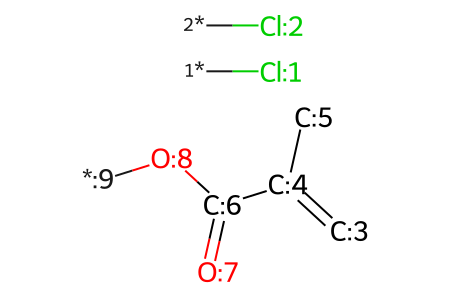

INFO:polymerist.rdutils.bonding.permutation:3 --x-> 4


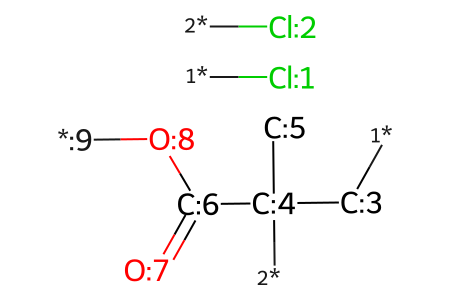

INFO:polymerist.rdutils.bonding.permutation:1 ----> 4


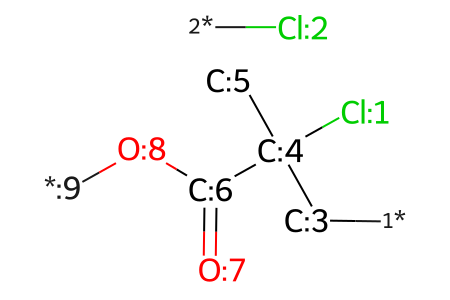

INFO:polymerist.rdutils.bonding.permutation:3 ----> 2


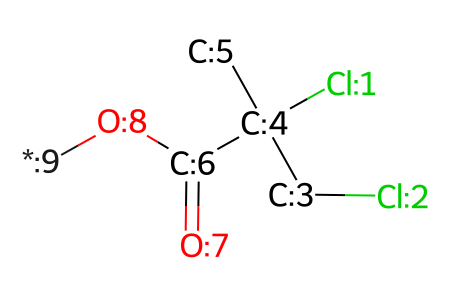

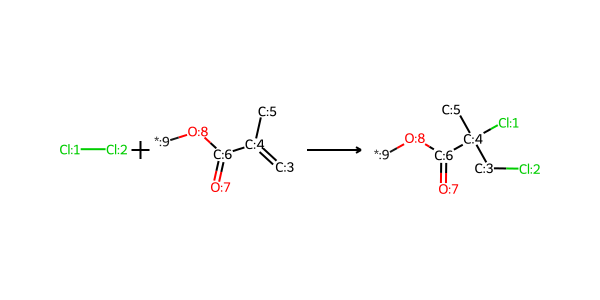

In [ ]:
from rdkit import Chem
from polymerist.rdutils.reactions.assembly import ReactionAssembler

methyl_methacrylate = Chem.MolFromSmarts('[C:1]=[C:2](-[C:3])-[C:4](=[O:5])-[O:6]-[*:7]')
dichlorine = Chem.MolFromSmarts('[Cl:1]-[Cl:2]')

display(methyl_methacrylate)
display(dichlorine)

assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between Cl2 and MMA
        dichlorine,
        methyl_methacrylate,
    ],
    #byproducts=None, 
    rxn_name='Alkene Chlorination',
)
display(assembler.reactants)

assembler.bond_derangement = {
    1 : (2, 4), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
    3 : (4, 2),  
}

ATRP_initiation_rxn = assembler.assemble_rxn(show_steps=True)
display(ATRP_initiation_rxn)

#### Link the chlorinated fragments together with ATRP

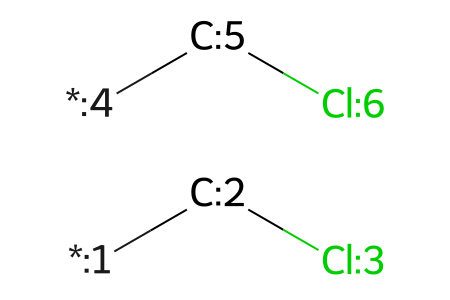

INFO:polymerist.rdutils.bonding.permutation:3 --x-> 2


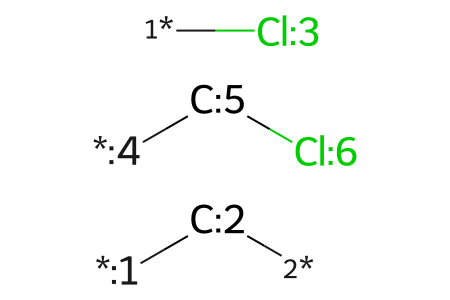

INFO:polymerist.rdutils.bonding.permutation:5 --x-> 6


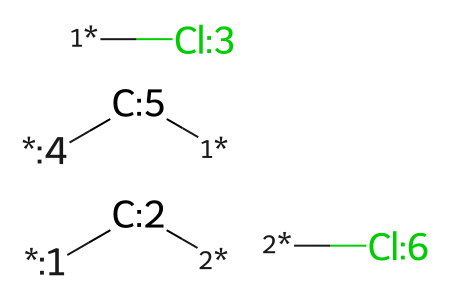

INFO:polymerist.rdutils.bonding.permutation:3 ----> 6


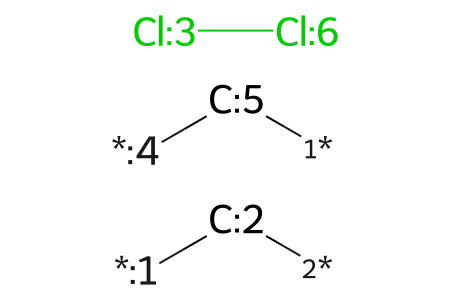

INFO:polymerist.rdutils.bonding.permutation:5 ----> 2


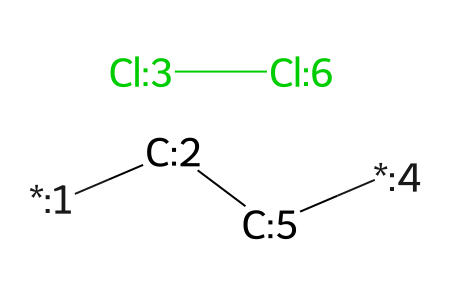

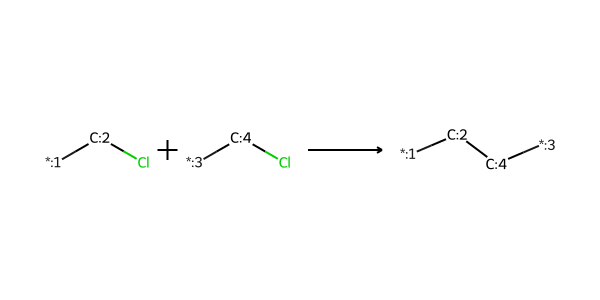

In [17]:
from rdkit import Chem
from polymerist.rdutils.reactions.assembly import ReactionAssembler

alkyl_chloride = Chem.MolFromSmarts('[*:1]-[C:2]-[Cl:3]')  # this is the moiety active in the ATRP reaction
assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between two alkyl chlorides
        Chem.Mol(alkyl_chloride),
        Chem.Mol(alkyl_chloride),
    ],
    byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
    rxn_name='atom-transfer radical polymerization',
)
display(assembler.reactants)

assembler.bond_derangement = {
    3 : (2, 6), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
    5 : (6, 2),    
}
ATRP_polymerization_rxn = assembler.assemble_rxn(show_steps=True)
display(ATRP_polymerization_rxn)

#### Try and react the activated monomers with stereo

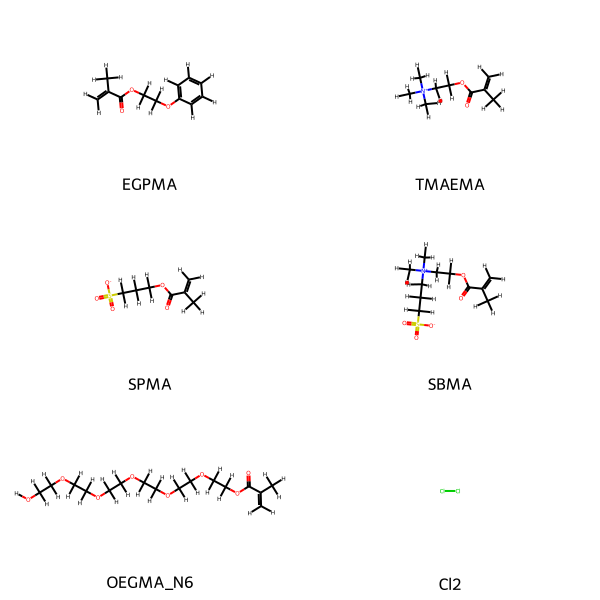

In [18]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles

monomer_smiles : dict[str, str] = {
    'SBMA' : 'CC(Cl)(CCl)C(=O)OCC[N+](C)(C)CCC[S+]([O-])([O-])=O',
    'EGPMA' : 'CC(Cl)(CCl)C(=O)OCCOC1=CC=CC=C1',
    'SPMA' : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])C([H])([H])S(=O)(=O)[O-])C([H])([H])[H]',
    'OEGMA_n6' : '[H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC(=O)C(=C([H])[H])C([H])([H])[H]'
}

# SMILES w/o Cl activation
monomer_smiles : dict[str, str] = {
    'EGPMA'    : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])Oc1c([H])c([H])c([H])c([H])c1[H])C([H])([H])[H]',
    'TMAEMA'   : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]',
    'SPMA'     : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])C([H])([H])S(=O)(=O)[O-])C([H])([H])[H]',
    'SBMA'     : '[H]C([H])=C(C(=O)OC([H])([H])C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])S(=O)(=O)[O-])C([H])([H])[H]',
    'OEGMA_N6' : '[H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC(=O)C(=C([H])[H])C([H])([H])[H]',
    'Cl2'      : '[Cl]-[Cl]'
}

monomers : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monomers.keys())


#### Run Initiation on all monomers

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)


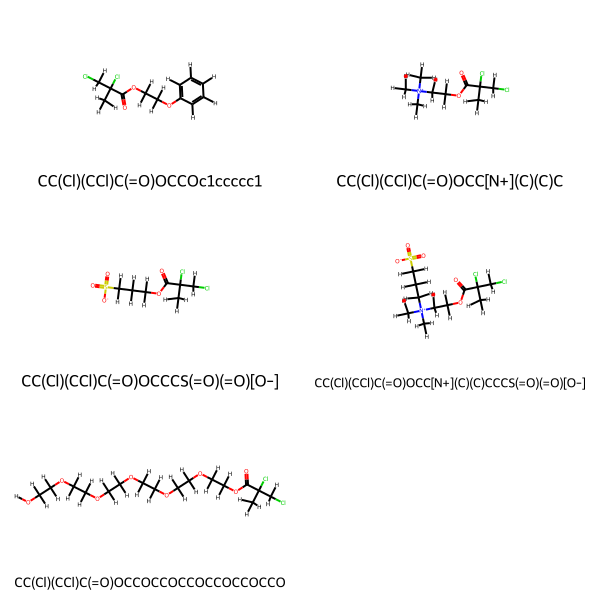

In [21]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

initiation_reactor = PolymerizationReactor(ATRP_initiation_rxn)
starting_monomers = initiation_reactor.propagate_pooled(
    monomers.values(),
    rxn_depth_max=0,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(starting_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=starting_monomers.keys())

activated_monomers = initiation_reactor.propagate_pooled(
    monomers.values(),
    rxn_depth_max=1,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)

to_remove = []
for x in activated_monomers:
    if x in starting_monomers:
        to_remove.append(x)

for x in to_remove:
    activated_monomers.pop(x, None)

MolsToGridImage(activated_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_monomers.keys())

#### Convert the SMILES of activated monomers into names and spec-compliant SMARTS

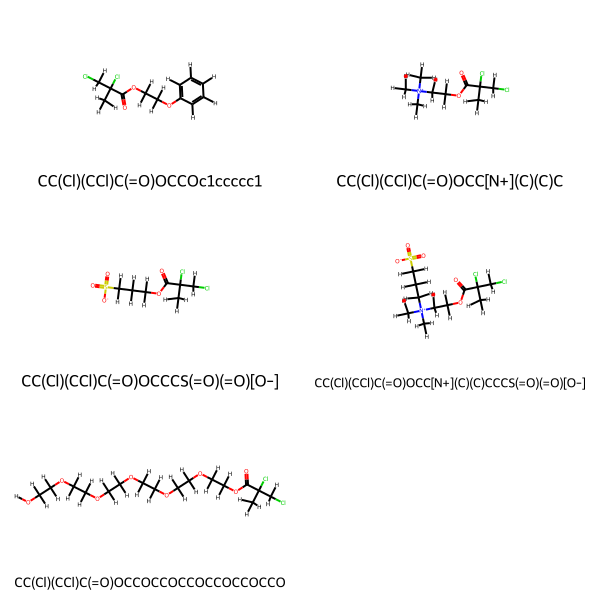

In [22]:
MolsToGridImage(activated_monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_monomers.keys())

In [23]:
from rdkit.Chem import rdFMCS

def partial_substruct_match(mol, query, threshold=0.8):
    mcs = rdFMCS.FindMCS([mol, query],
                         completeRingsOnly=False,
                         matchValences=False,
                         ringMatchesRingOnly=False,
                         timeout=5)
    if not mcs.smartsString:
        return False
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    n_mcs_atoms = mcs_mol.GetNumAtoms()
    n_query_atoms = query.GetNumAtoms()
    return (n_mcs_atoms / n_query_atoms) >= threshold

def find_first_partial_match(monomers, query_mol, threshold=0.77):
    for name, monomer in monomers.items():
        if partial_substruct_match(monomer, query_mol, threshold=threshold):
            return name  # return first match immediately
    return None  # no match found


In [104]:
monomers

{'EGPMA': <rdkit.Chem.rdchem.Mol at 0x14ccf969e6c0>,
 'TMAEMA': <rdkit.Chem.rdchem.Mol at 0x14ccf969edc0>,
 'SPMA': <rdkit.Chem.rdchem.Mol at 0x14ccf969e7a0>,
 'SBMA': <rdkit.Chem.rdchem.Mol at 0x14ccf969ef80>,
 'OEGMA_N6': <rdkit.Chem.rdchem.Mol at 0x14ccf969ec00>,
 'Cl2': <rdkit.Chem.rdchem.Mol at 0x14ccf969eab0>}

In [108]:
activated_monomers

{'CC(Cl)(CCl)C(=O)OCCOc1ccccc1': <rdkit.Chem.rdchem.Mol at 0x14ccf956de00>,
 'CC(Cl)(CCl)C(=O)OCC[N+](C)(C)C': <rdkit.Chem.rdchem.Mol at 0x14ccf956dfc0>,
 'CC(Cl)(CCl)C(=O)OCCCS(=O)(=O)[O-]': <rdkit.Chem.rdchem.Mol at 0x14ccf956e500>,
 'CC(Cl)(CCl)C(=O)OCC[N+](C)(C)CCCS(=O)(=O)[O-]': <rdkit.Chem.rdchem.Mol at 0x14ccf956dd20>,
 'CC(Cl)(CCl)C(=O)OCCOCCOCCOCCOCCOCCO': <rdkit.Chem.rdchem.Mol at 0x14ccf956e5e0>}

EGPMA
TMAEMA
SPMA
SBMA
OEGMA_N6


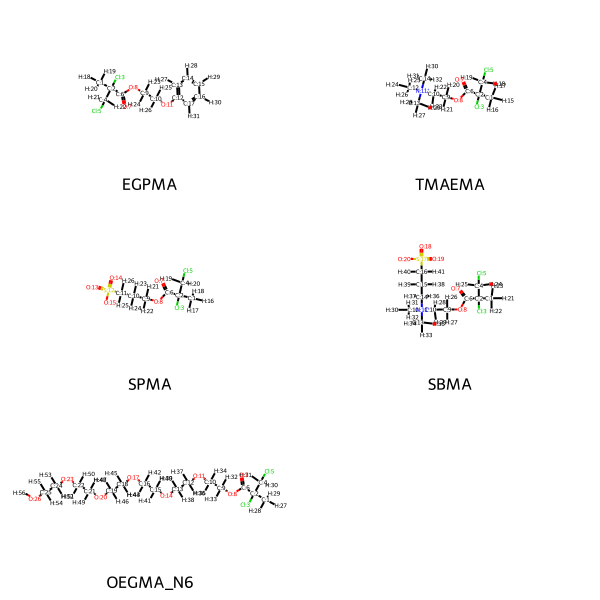

In [39]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports

activated_named_monomers_Smiles : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in activated_monomers.items():
    
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(monomers, query_mol, threshold=0.77)
    
    print(parent_mol_name)
    activated_named_monomers_Smiles[f'{parent_mol_name}'] = canon_smiles

    
monogrp = MonomerGroup(activated_named_monomers_Smiles)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

#### Run the polymerization reaction on activated monomers

In [40]:
activated_named_monomers : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in activated_named_monomers_Smiles.items()
}

activated_named_monomers

{'EGPMA': <rdkit.Chem.rdchem.Mol at 0x14ccf80fe6c0>,
 'TMAEMA': <rdkit.Chem.rdchem.Mol at 0x14ccf80ffed0>,
 'SPMA': <rdkit.Chem.rdchem.Mol at 0x14ccf3384040>,
 'SBMA': <rdkit.Chem.rdchem.Mol at 0x14ccf3384120>,
 'OEGMA_N6': <rdkit.Chem.rdchem.Mol at 0x14ccf33844a0>}

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


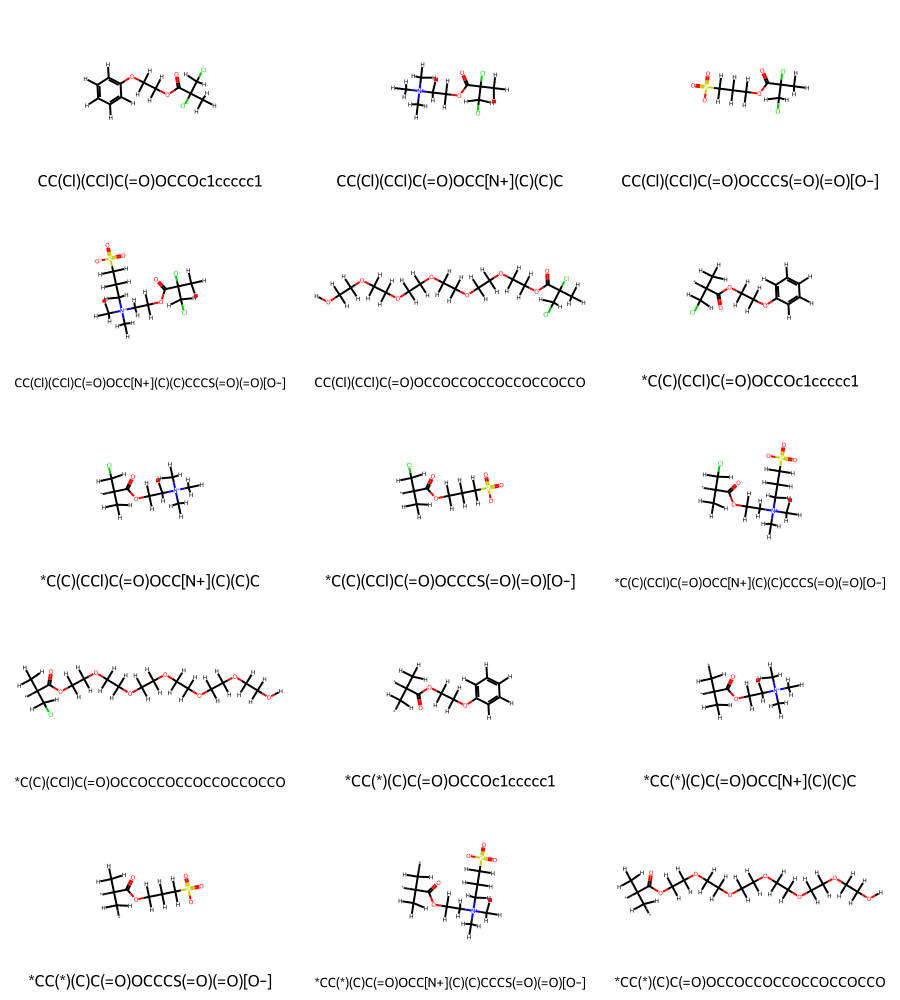

In [43]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

reactor = PolymerizationReactor(ATRP_polymerization_rxn)
activated_fragments = reactor.propagate_pooled(
    activated_named_monomers.values(),
    rxn_depth_max=5,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
    allow_resampling=True, 
)
MolsToGridImage(activated_fragments.values(), molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=activated_named_fragments.keys())

#### Rename the fragments ready for polymerization

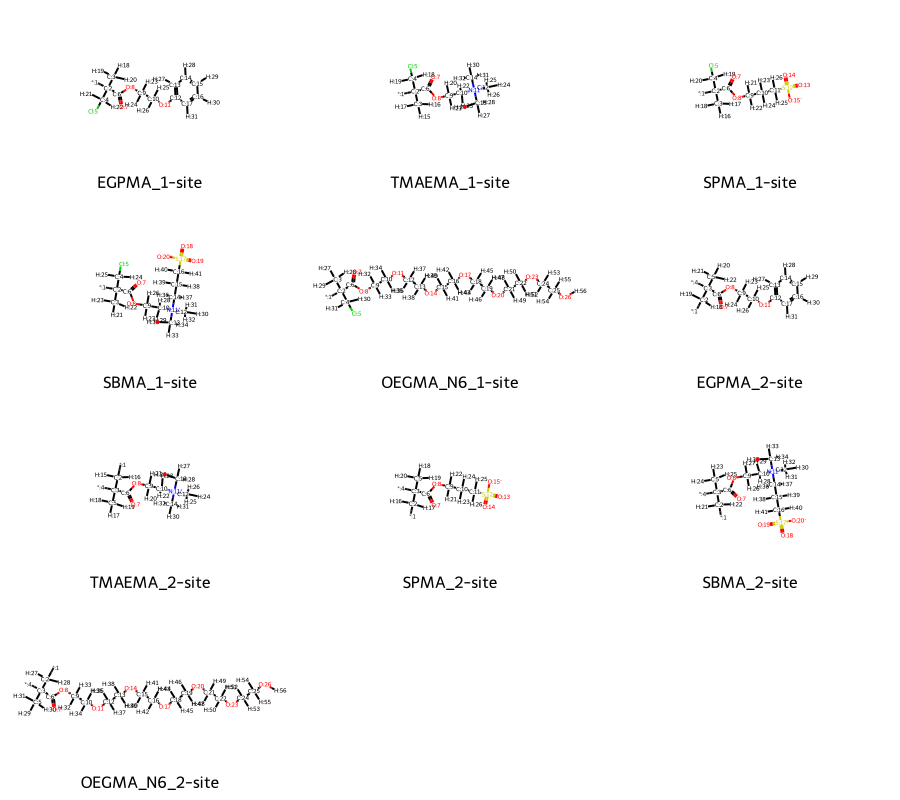

In [48]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports

named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(monomers, query_mol, threshold=0.77)
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

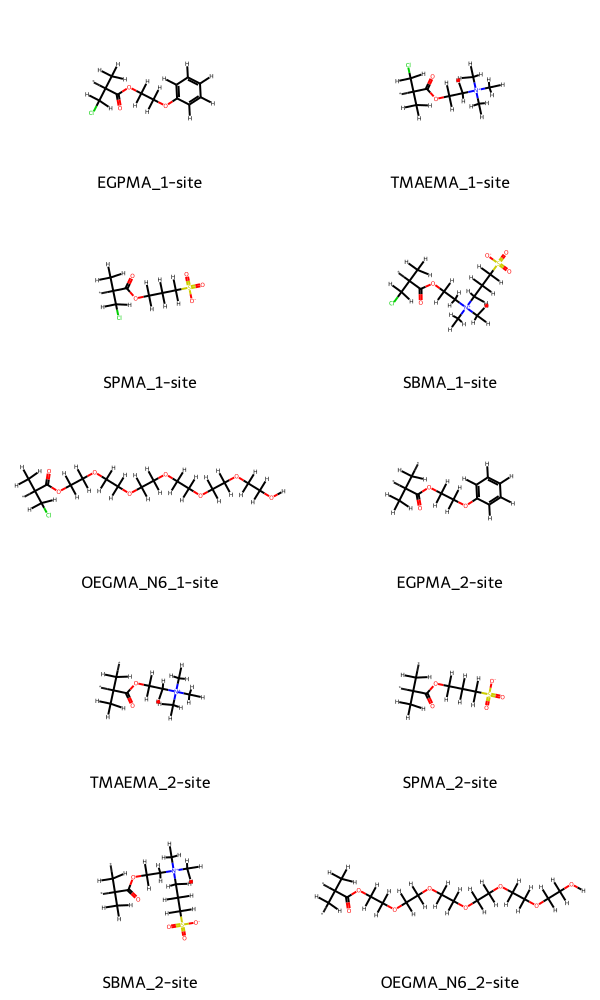

In [53]:
# activated because these have Cl, named because they are labeled by
# a semantically meaningful name
activated_named_fragments : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in named_fragments.items()
}

MolsToGridImage(activated_named_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=activated_named_fragments.keys())

#### Terminate the 1-site fragments
* We don't want to have Cl in our final polymer
* This was just added so we could run our reaction

In [90]:
# rxn = AllChem.ReactionFromSmarts("[C:3]-[C:2](-[Cl])(-[C:1]-[*:8])-[C:4](=[O:5])-[O:6]-[*:7] >> [C:3]=[C:2](-[C:1]-[*:8])-[C:4](=[O:5])-[O:6]-[*:7]")
# display(rxn)

In [117]:
chlor_methyl_methacrylate = Chem.MolFromSmarts('[C:3](-[Cl:10])-[C:2](-[*:9])(-[C:1])-[C:4](=[O:5])-[O:6]-[*:7]')  # this is the moiety active in the ATRP reaction

assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between our reactive methacrylate and an imaginary HCl
        Chem.Mol(chlor_methyl_methacrylate),
        Chem.Mol(Chem.MolFromSmarts("[H]-[Cl]"))
    ],
    byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
    rxn_name='Termination',
)
#display(assembler.reactants)

assembler.bond_derangement = {
    1 : (2, 10), # keys are the indices of pivot atoms; 
    11 : (10, 2) # values are the atom indices to which
                 # the pivot was and will be bonded, respectively    
}

termination_rxn = assembler.assemble_rxn(show_steps=False)
#display(termination_rxn)

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 5 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 2 reaction step(s) or more


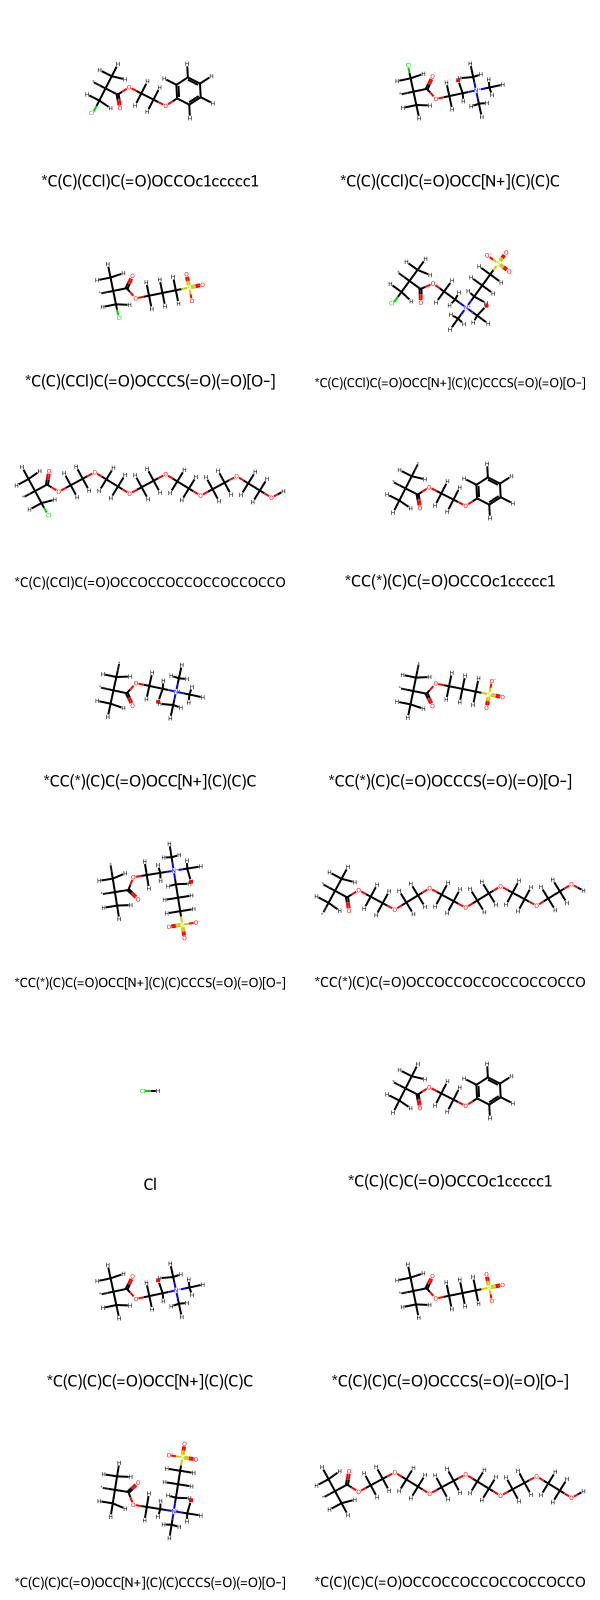

In [96]:
# Add in HCl so we can run termination
# We need to explicitly include this extra molecule in the
# Pool of reactants
activated_named_fragments["HCl"] = Chem.MolFromSmarts("[H]-[Cl]")

termination_reactor = PolymerizationReactor(termination_rxn)
terminated_fragments = termination_reactor.propagate_pooled(
    activated_named_fragments.values(),
    # rxn_depth_max=3,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(terminated_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=terminated_fragments.keys())

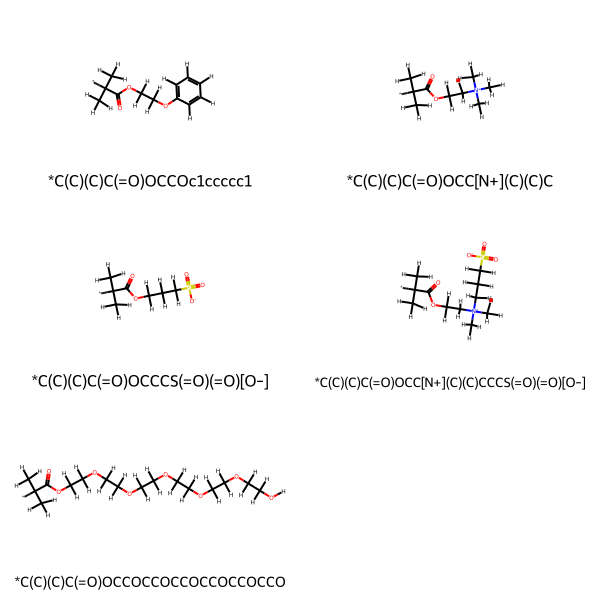

In [100]:
# Remove all of the non-fragments
to_remove = []
for x in terminated_fragments:
    if x in activated_fragments:
        to_remove.append(x)

for x in to_remove:
    terminated_fragments.pop(x, None)

terminated_fragments.pop('Cl', None) # Get rid of the Cl we added

MolsToGridImage(terminated_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=terminated_fragments.keys())

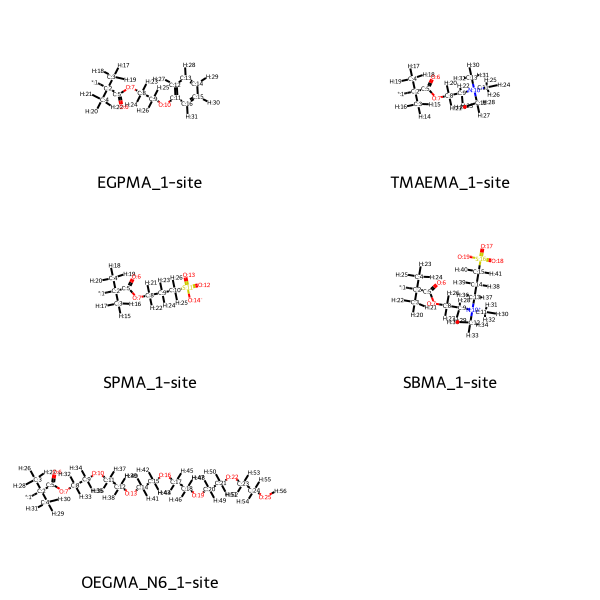

In [112]:
terminated_named_monomers_Smiles : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in terminated_fragments.items():

    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = find_first_partial_match(activated_named_fragments, query_mol, threshold=0.77)
    
    terminated_named_monomers_Smiles[f'{parent_mol_name}'] = canon_smiles

monogrp = MonomerGroup(terminated_named_monomers_Smiles)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

In [121]:
terminated_named_fragments: dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in terminated_named_monomers_Smiles.items()
}

terminated_named_fragments

{'EGPMA_1-site': <rdkit.Chem.rdchem.Mol at 0x14ccf32dee30>,
 'TMAEMA_1-site': <rdkit.Chem.rdchem.Mol at 0x14ccf32deea0>,
 'SPMA_1-site': <rdkit.Chem.rdchem.Mol at 0x14ccf32def10>,
 'SBMA_1-site': <rdkit.Chem.rdchem.Mol at 0x14ccf32def80>,
 'OEGMA_N6_1-site': <rdkit.Chem.rdchem.Mol at 0x14ccf32deff0>}

In [ ]:
# Remove HCl from activated_named_fragments
# Pull out the 2-sites from activated_named_fragments (they're correct)
# Merge with the terminated 1-sites (we just made these)
# Write to a MonomerGroup

activated_named_fragments.pop("HCl", None)


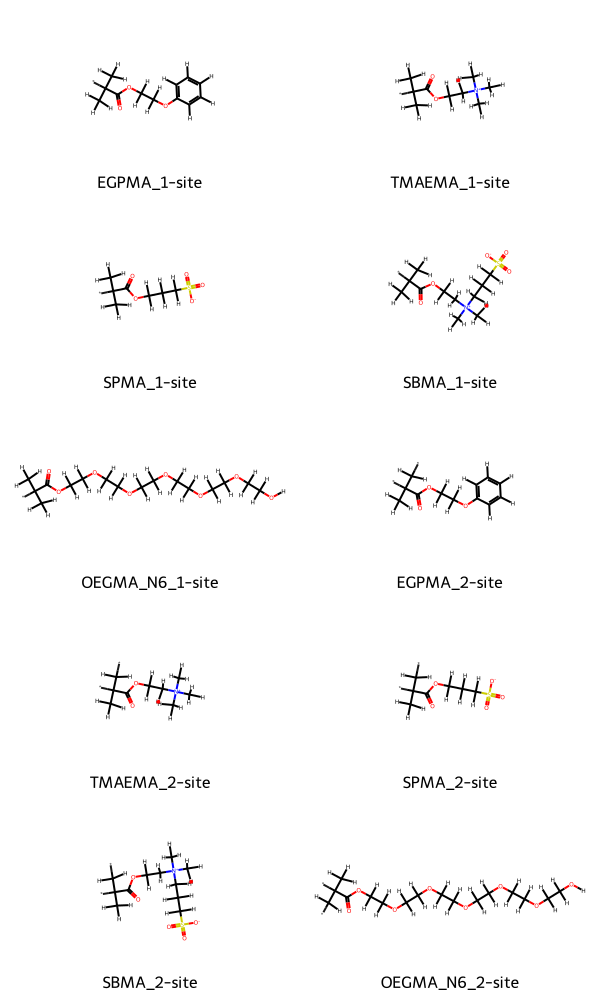

In [124]:
# Take the union of these dicts, the right hand dict takes precedence
# When keys are shared

all_correct_named_fragments = activated_named_fragments | terminated_named_fragments
MolsToGridImage(all_correct_named_fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=all_correct_named_fragments.keys())

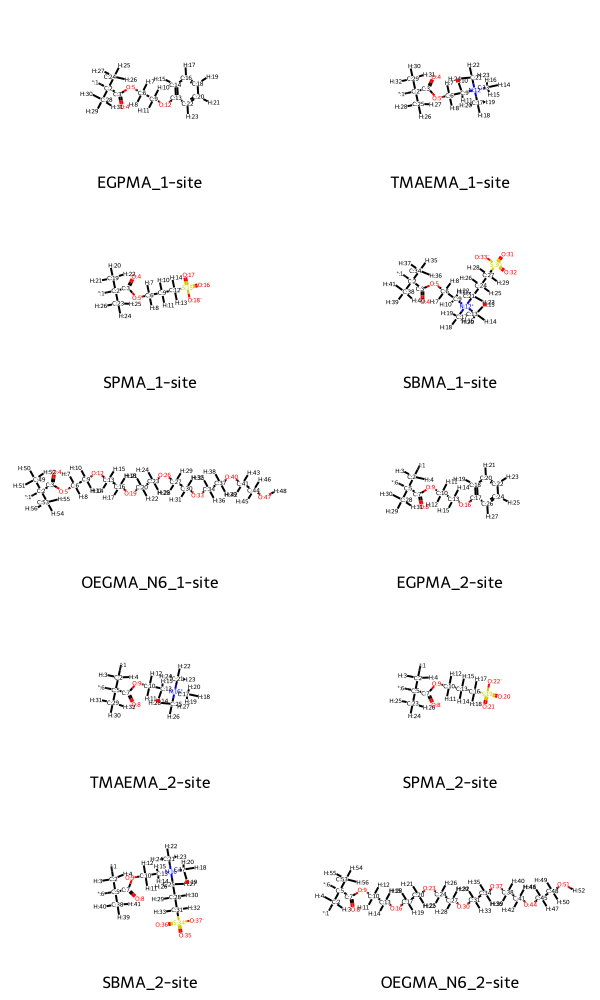

In [125]:
# Put everything into a MonomerGroup
all_correct_named_fragments_Smiles : dict[str, Smiles] = {}

for parent_mol_name, fragment_mol in all_correct_named_fragments.items():
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    all_correct_named_fragments_Smiles[parent_mol_name] = Chem.MolToSmarts(fragment_mol)

monogrp = MonomerGroup(all_correct_named_fragments_Smiles)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

#### Build a linear polymer

In [140]:
import numpy as np

# draw probabilities according to experiment
# 3:3:2 + 5% SBMA, SPMA, OEGMA, EGPMA

probas = [0.3583, 0.3583, 0.2334, 0.05]
chars = ['A', 'B', 'C', 'D']
N = 10

# Make mapper dict for the one-sites
# These will be used to terminate the polymer
term_orient_mapper = {
    'A' : 'SBMA_1-site',
    'B' : 'SPMA_1-site',
    'C' : 'OEGMA_N6_1-site',
    'D' : 'EGPMA_1-site',
    'E' : 'TMAEMA_1-site'
}

# rename to 3-letter residue names in PDB file
resname_map={ 
        'SBMA_1-site'     : 'SB1',
        'SBMA_2-site'     : 'SB2',
        'SPMA_1-site'     : 'SP1',
        'SPMA_2-site'     : 'SP2',
        'OEGMA_N6_1-site' : 'OE1',
        'OEGMA_N6_2-site' : 'OE2',
        'EGPMA_1-site'    : 'EG1',
        'EGPMA_2-site'    : 'EG2',
        'TMAEMA_1-site'   : 'TM1',
        'TMAEMA_2-site'   : 'TM2'
    }

# sample N characters according to the probabilities
polymer_seq = ''.join(np.random.choice(chars, size=N, p=probas))

# Define a canonical form: min of the string and its reverse
def canonical(s):
    return min(s, s[::-1])

# Convert all strings to their canonical form
canonical_poly_seq = canonical(polymer_seq) 

print("Raw Polymer Sequence:", ''.join(polymer_seq))
print("Canonical Polymer Sequence:", ''.join(canonical_poly_seq))

Raw Polymer Sequence: BBABABDCAC
Canonical Polymer Sequence: BBABABDCAC


In [134]:
canonical_poly_seq[1:-1]

'ADCDAAAB'

In [141]:
from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path


OUTPUT_DIR = Path('Building_Demos') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

WORKING_DIR = OUTPUT_DIR / 'ATRP_demo'
WORKING_DIR.mkdir(exist_ok=True)

project_name : str = 'ATRP_polymer_brush'

In [142]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb, mbmol_to_rdkit_pdb
from polymerist.rdutils.rdcoords.piercing import summarize_ring_piercing
from polymerist.polymers.building import build_linear_polymer, mbmol_to_rdkit_pdb
from polymerist.polymers.building import mbmol_to_rdmol

                      # JRL: I don't think the below comment is correct
n_monomers : int = 10 # number of MIDDLE monomers (not including end groups)

# not strictly necessary, but nice to show you can reload these fragments from prior builds
# monogrp = MonomerGroup.from_file(fragments_path)
monogrp.term_orient = { # set explicit orientation for head and tail terminal groups
    'head' : term_orient_mapper[canonical_poly_seq[0]],
    'tail' : term_orient_mapper[canonical_poly_seq[-1]],
}

successful_build = False
while not successful_build:

# assemble polymer chain
    chain = build_linear_polymer(
        monogrp,
        n_monomers=n_monomers,
        sequence=canonical_poly_seq[1:-1], # omit the head and tail groups
        energy_minimize=True,
        allow_partial_sequences=True
    )

    poly_mol = mbmol_to_rdmol(chain)
    pinprics_out = summarize_ring_piercing(poly_mol)

    if pinprics_out == {}:
        successful_build = True
        print("Build Success!")
    else:
        print("PIERCING REDO")
        print(pinprics_out)


polymer_name = f'test_{n_monomers}-mer'
pdb_path = assemble_path(WORKING_DIR, polymer_name, extension='pdb')
mbmol_to_openmm_pdb(
    pdb_path,
    chain,
    resname_map=resname_map
)

chain.visualize()

INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'SPMA_1-site', 'tail': 'OEGMA_N6_1-site'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "BABABDCA" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 1 whole 8-sequence repeat(s), namely with the sequence [SPMA_1-site] + 1*[BABABDCA] + [OEGMA_N6_1-site]
INFO:polymerist.polymers.building.linear:Registering middle monomer EGPMA_2-site (block identifier "B")
INFO:polymerist.polymers.building.linear:Registering middle monomer TMAEMA_2-site (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering middle monomer SPMA_2-site (block identifier "D")
INFO:polymerist.polymers.building.linear:Registering middle monomer SBMA_2-site (block identifier "C")
INFO:polymerist.polymers.building.linear:Registering terminal monomer SPMA_1-site (orientation "head")
INFO:polymerist.polymers.building.linear:Registerin

Build Success!


/projects/jola3134/software/anaconda/envs/polymerist-env/lib/python3.11/site-packages/mbuild/conversion.py:1000: UserWarning: System is not charge neutral. Total charge is 1.
  warn(f"System is not charge neutral. Total charge is {compound.charge}.")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.